# Experiment 1: The Harmonization Paradox (Site Classification)
Date: 2025-11-03

## Introduction
Based on the previous findings, standard harmonization methods (`SiteWiseScaler`, `ComBat`) were found to be insufficient. They successfully reduced feature-level differences (like mean and variance) but paradoxically made the source hospital *easier* to classify. This suggest that:
1. The site effect is a complex, high-dimensional signal.
2. These methods, by removing simple noise, may be "cleaning" the data in a way that amplifies the underlying, unique signature of each hospital.

In this experiment we add `CovBat` - a more advanced method designed to also harmonize the covariance structure, to see if it can solve the problem.

### Goals fot this experiment:
- Run raw vs. sitewise vs. neurocombat vs. covbat on the site classification task.
- Run SHAP and data-space analyses to understand what the models are learning.
- Run all 4 methods on the pathology classification task (LOSO).

## Setup

In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [20]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from src.models import run_site_classification
from src.visualization.eeg_plots import plot_eeg_feature_overview

LOG_FILE_PATH = 'results/logs/03_paradox_analysis/exp01_site_clf.log'
RESULTS_PATH = 'results/tables/03_paradox_analysis/exp01_site_clf/exp01_site_clf_results.csv'

PIPELINE_SAVE_DIR = 'models/03_paradox_analysis/exp01_site_clf_pipelines'
SHAP_DATA_SAVE_DIR = 'results/shap_data/03_paradox_analysis/exp01_site_clf'


METHODS = ['raw', 'sitewise', 'combat', 'neurocombat', 'covbat']

In [3]:
logger = logging.getLogger('src.models.run_site_classification')
logger.setLevel(logging.INFO)

if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

file_handler = logging.FileHandler(LOG_FILE_PATH, mode='w')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

## Part 1: Site Classification

### Run Experiment: Site Classification

In [3]:
RUN = False
if RUN:
    for method in METHODS:
        run_site_classification.run_experiment(harmonization_method=method)

In [5]:
RESULTS_PATH = 'results/tables/03_paradox_analysis/exp01_site_clf/exp01_site_clf_results.csv'
results_df = pd.read_csv(RESULTS_PATH)

In [6]:
mean_results_df = results_df.groupby(['method']).mean().drop('fold', axis=1)

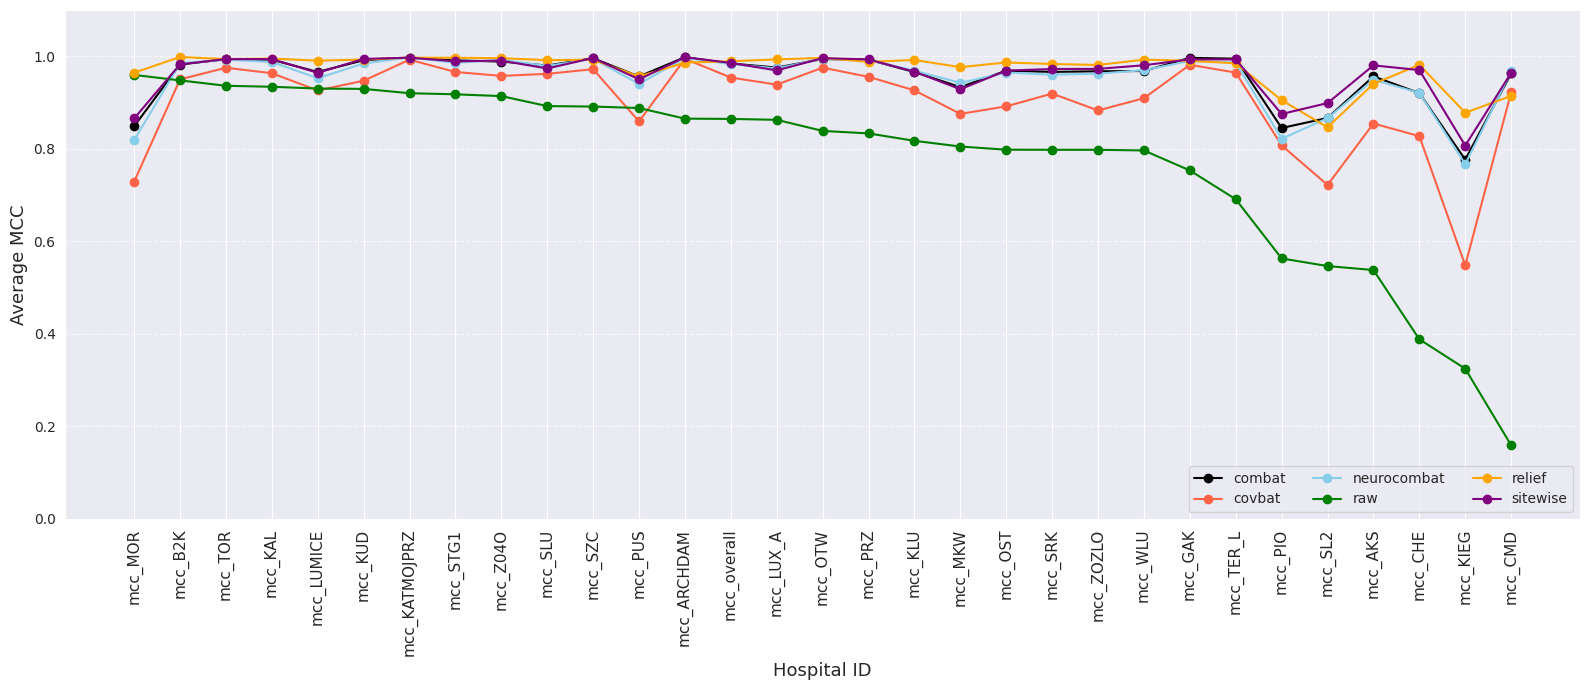

In [7]:
color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

plt.figure(figsize=(16, 7))

reference_series = mean_results_df.loc['raw']
sort_idx = reference_series.values.argsort()[::-1]
class_labels_sorted = reference_series.index.values[sort_idx]
for method_idx, method in enumerate(mean_results_df.index):
    results_series = mean_results_df.loc[method]
    mcc_values = [results_series.get(h, np.nan) for h in class_labels_sorted]

    plt.plot(
        class_labels_sorted,
        mcc_values,
        marker='o',
        linestyle='-',
        color=color_grid[method_idx],
        label=f"{method}"
    )

plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)
plt.legend(loc='lower right', fontsize=10, ncol=3)
plt.tight_layout()

plt.show()

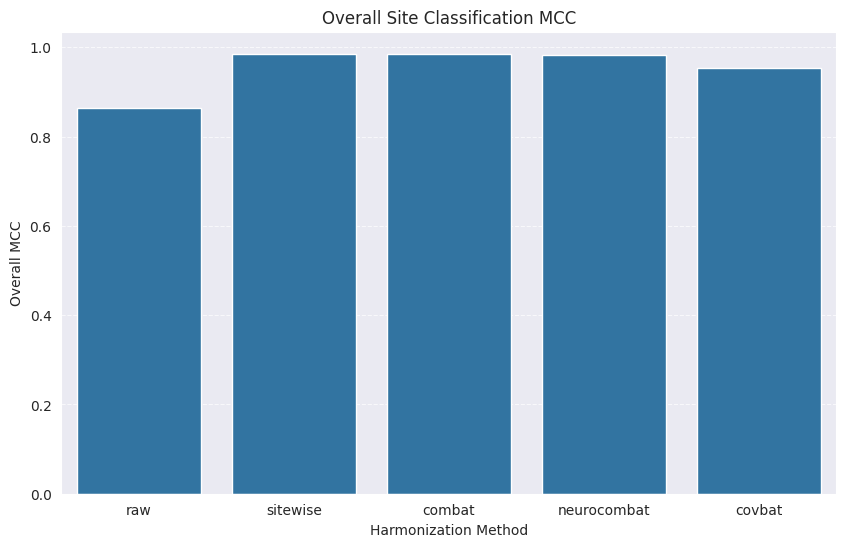

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_results_df, x='method', y='mcc_overall', order=['raw', 'sitewise', 'combat', 'neurocombat', 'covbat'])
plt.title('Overall Site Classification MCC')
plt.ylabel('Overall MCC')
plt.xlabel('Harmonization Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### SHAP analysis

In [21]:
pipelines = {}
test_data = {}
logging.info("Loading all pipelines and test data...")
for method in METHODS:
    pipeline_path = os.path.join(PIPELINE_SAVE_DIR, f'{method}_pipeline_fold0.joblib')
    pipelines[method] = joblib.load(pipeline_path)

    data_path = os.path.join(SHAP_DATA_SAVE_DIR, f'{method}_test_data_fold0.parquet')
    test_data[method] = pd.read_parquet(data_path)

In [22]:
transformed_X = {}
feature_names = {}
for method in METHODS:
    if method not in pipelines:
        continue
    pipeline = pipelines[method]
    data_df = test_data[method]

    y_test = data_df['y_true_hospital']
    X_test = data_df.drop(columns=['y_true_hospital'])

    model = pipeline.named_steps['clf']
    feature_names[method] = model.feature_names_

    if method == 'raw':
        X_transformed = X_test
    else:
        X_transformed = pipeline.named_steps['harmonize'].transform(X_test)

    transformed_X[method] = pd.DataFrame(X_transformed, columns=feature_names[method])

/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [23]:
shap_values = {}
explainers = {}
for method in METHODS:
    if method not in pipelines:
        continue

    model = pipelines[method].named_steps['clf']
    X = transformed_X[method]

    explainers[method] = shap.TreeExplainer(model)
    shap_values[method] = explainers[method](X)

In [ ]:
for method in METHODS:
    mean_abs_shap = np.mean(np.abs(shap_values[method].values), axis=(0, 2))
    shap_series = pd.Series(mean_abs_shap, index=transformed_X[method].columns)

    fig, axs = plot_eeg_feature_overview(
        features_series=shap_series,
        figure_title=f"Method: {method}"
    )
    save_path = f"results/figures/03_paradox_analysis/exp01_{method}_shap_overview.png"
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    logging.info(f"Saved plot to {save_path}")

    plt.show()

In [25]:
os.makedirs("logs/output", exist_ok=True)

(5314, 2850, 30)

In [38]:
for method in METHODS:
    mean_abs_shap = np.mean(np.abs(shap_values[method].values), axis=0)
    model = pipelines[method].named_steps['clf']
    for idx, hospital_id in enumerate(model.classes_):
        shap_series = pd.Series(mean_abs_shap[:,idx], index=transformed_X[method].columns)

        fig, axs = plot_eeg_feature_overview(
            features_series=shap_series,
            figure_title=f"Method: {method}, Hospital ID: {hospital_id}"
        )

        save_path_dir = f"results/figures/03_paradox_analysis/{method}"
        os.makedirs(save_path_dir, exist_ok=True)
        save_path = save_path_dir + f"/exp01_{method}_{hospital_id}_shap_overview.png"
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        logging.info(f"Saved plot to {save_path}")

        plt.close(fig)